In [1]:
from significance_of_mean_cuda import significance_of_mean_cuda
import pandas as pd
import numpy as np
import time
from scipy.stats import mannwhitneyu, ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [2]:
%load_ext cython
%load_ext rpy2.ipython



R[write to console]: Warning:
R[write to console]:  namespace ‘pbdZMQ’ is not available and has been replaced
by .GlobalEnv when processing object ‘.pbd_env’

/home/ekvall/anaconda3/envs/my-r-env/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/ekvall/anaconda3/envs/my-r-env/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [3]:
%%R

require(ggplot2)
install.packages("devtools")
library("devtools")
install_github("bdsegal/fastPerm")

library(fastPerm)

R[write to console]: Loading required package: ggplot2

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/devtools_2.2.2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 375464 bytes (366 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to cons

In [4]:
%%R
    runFastPerm <- function(x,y,output, n_samples) {
        e <- list(mode="vector",length=n_samples)
        for (i in 1:n_samples) {
      
            mStopDiffMean(x[[i]], y[[i]])
            valX = fastPerm(x[[i]], y[[i]], testStat = diffMean)
            
            valX <-unlist(valX)

      
            output[[i]] <- as.numeric(valX[1])
      
            }
    

    return(output)


    }

In [5]:
def fastPerm(A,B):
    x = pd.DataFrame(A, columns=list(range(A.shape[1]))).T
    y = pd.DataFrame(B, columns=list(range(B.shape[1]))).T
    n_samples = x.shape[1]
    outputDf = pd.DataFrame(n_samples * [0], columns=["output"]).T
    
    %R -i x
    %R -i y
    %R -i outputDf
    %R -i n_samples
    
    
    %R out <- runFastPerm(x,y, outputDf, n_samples)
    
    
    %R -o out
    return list(out.T["output"].values)

In [6]:
def exactTest(A,B, bins=10, one_side=False):
    SGM = significance_of_mean_cuda(bins, dtype_v=np.uint32,dtype_A=np.float64, )
    SGM.run(np.asarray(A),np.asarray(B), midP=True)
    if one_side:
        return SGM.get_p_values()
    else:
        return [2 * min( p, (1-p)) for p in SGM.get_p_values()]

def MWU(A, B, one_side=False):
    p_mw = list()
    for a,b in zip(A, B):
        if one_side:
            p_mw.append(mannwhitneyu(a,b, alternative="less")[1])
        else:
            p_mw.append(mannwhitneyu(a,b, alternative="two-sided")[1])
    return p_mw

def ttests(A,B, one_side=False):
    p_t = list()
    for x, y in zip(A, B):
        t, p = ttest_ind(y, x)
        if one_side:
            p = p/2
            if t<0:
                p = 1-p
        p_t.append(p)
    return p_t


In [7]:
def getPrediction(A,B):
    Data = dict()
    
    Data["eList"] = exactTest(B, A, 35, False)
    
    print(  Data["eList"])
    Data["fpList"] = fastPerm(np.array(A),np.array(B))
    Data["mwuList"] = MWU(A, B, False)
    Data["ttList"] = ttests(A, B, False)
    print(  Data["ttList"])
    return Data

In [8]:
def getSynteticData(func, setN=20, sampleN=2_000, mean=0, std=1,seed=1):
    np.random.seed(seed)
    AN, BN = [func(mean,std,setN) for i in range(sampleN)], [func(0,std,setN) for i in range(sampleN)]
    return AN, BN

In [9]:
def relError(Data):
    pe_list = Data["eList"] 
    p_fp_list = Data["fpList"] 
    pmw_list = Data["mwuList"] 
    pt_list = Data["ttList"]
    
    errorDict = dict()
    errorDict["eList"] = list()
    errorDict["fpList"] = list()
    errorDict["mwuList"] = list()
    for P_fp, P_e, P_t, P_mw in zip(p_fp_list, pe_list, pt_list, pmw_list):
        print(P_fp)
        print(P_e)
        print(P_t)
        print(P_mw)
        errorDict["fpList"].append((P_fp - P_t) / P_t)
        errorDict["eList"].append((P_e - P_t) / P_t)
        errorDict["mwuList"].append((P_mw - P_t) / P_t)
    return errorDict
        

In [13]:
def getErrors(pValList, pTtestList, rel=True):
    relatvieErrorList = list()
    for pv, pt in zip(pValList, pTtestList):
        if rel:
            relatvieErrorList.append(relError(pv, pt))
        else:
            relatvieErrorList.append(frac(pv, pt))
            
    return relatvieErrorList

def relError(x,y):
    return frac((x - y), y) 
def frac(x,y):
    return x / y

In [83]:
def preparePandas(timeData, sampleSizes,label=None):
    preparePd = list()
    for time, sample in zip(timeData, sampleSizes):
        for t in time:
            if label:
                preparePd.append([t, sample, label])
            else:
                preparePd.append([t, sample])
    return preparePd

def SNSMultipleboxPlot(allEerrorList, Bin, allMWUList=None, allFPList=None, log=True, 
                       path=None, test_type="setSize", relError=True, dashed=False,
                       ylim=False):
    
    plt.figure(figsize=(16, 10))
    
    dataParallel = preparePandas(allEerrorList, Bin, "Parallel Green")
    
    data= dataParallel
    
    if allFPList:
        dataFastApprox = preparePandas(allFPList, Bin, "FastPerm")
        data += dataFastApprox
    if allMWUList:
        MannWhitneyApprox = preparePandas(allMWUList, Bin, "Mann–Whitney $\it{U}$ test")
        data += MannWhitneyApprox
    
    sns.set(style="white")
    sns.set_context("talk")
    
    pdData = pd.DataFrame(data, columns=['error','bins', 'Method'])
    
    if test_type=="setSize":
        snsPlot = sns.boxplot(x="bins", y="error", data=pdData, hue="Method")
    else:
        snsPlot = sns.boxplot(x="bins", y="error", data=pdData, color="skyblue")
        
    
    if relError:
        plt.ylabel(r"Relative error $\big(|\frac{p_{*}-p_{t}}{p_{t}}|)$",fontsize=25)
    else:
        plt.ylabel(r"$\frac{p_{*}}{p_{t}}$",fontsize=45)
        
    if test_type=="windowSize":
        plt.xlabel(r"$n_{w}$",fontsize=45)
    else:
        plt.xlabel(r"$n$",fontsize=45)
    
    sns.set_style("ticks")
    sns.despine()
    plt.tight_layout()
    plt.gcf().subplots_adjust(left=0.30)
    
     
    
    if log:
        if allFPList and allMWUList:
            MAX = max(np.max(allEerrorList), np.max(allFPList), np.max(allMWUList))
            MIN = min(np.min(allEerrorList), np.min(allFPList), np.min(allMWUList))
        elif allFPList:
            MAX = max(np.max(allEerrorList), np.max(allFPList))
            MIN = min(np.min(allEerrorList), np.min(allFPList))
        elif allMWUList:
            MAX = max(np.max(allEerrorList), np.max(allMWUList))
            MIN = min(np.min(allEerrorList), np.min(allMWUList))
        else:
            MAX = np.max(allEerrorList)
            MIN = np.min(allEerrorList)
         

        if dashed:
            plt.axhline(0, ls=':', color="black", linewidth=3)
        
            
        #RANGE = np.arange(np.floor(MIN), np.ceil(MAX), 100)
        RANGE = np.arange(np.floor(MIN), np.ceil(MAX))
        
        if not relError:
            if ylim and ylim[1]<10:
                RANGE = np.array(sorted(list(RANGE) + [np.log10(0.5), np.log10(2)]))
            else:
                RANGE = np.array(sorted(list(RANGE)))

        plt.yticks(RANGE, 10.0**RANGE)

        
        
    if test_type=="setSize":
        plt.legend().set_title('')
    
    #€plt.yticks([0.5, 1, 2])
    
    
    if ylim:
        plt.ylim(np.log10(ylim[0]) ,np.log10(ylim[1]))
        path += "_zoom"
        
        plt.xticks(size = 32)
        plt.yticks(size = 32)
    else:
        plt.xticks(size = 32)
        plt.yticks(size = 25)
        
    

    
    if path:
        fig = snsPlot.get_figure()
        fig.savefig(path)

In [11]:
setSize = [10,50,100,150,200,250,300]

In [22]:
def getPvalues(mean=0.2):
    allEerrorList1, allFracList1 = list(), list()
    allMWUList1, allFracMWUList1 = list(), list()
    allFPList1, allFracFPList1 = list(), list()
    for setS in setSize:
        Anorm0, Bnorm0 = getSynteticData(np.random.normal, mean=mean, setN=setS,sampleN=50)
        ptTest  = ttests(Anorm0, Bnorm0)
    
        peList = exactTest(Anorm0, Bnorm0, bins=30)
        ExactErrorList = getErrors(peList, ptTest)
        ExactFracList = getErrors(peList, ptTest, False) 
        allEerrorList1.append(np.log10(np.abs(ExactErrorList)))
        allFracList1.append(np.log10(ExactFracList))
    
        pmwList = MWU(Anorm0, Bnorm0)
        MWUErrorList = getErrors(pmwList, ptTest)
        MWUFracList = getErrors(pmwList, ptTest, False) 
        allFracMWUList1.append(np.log10(MWUFracList))
        allMWUList1.append(np.log10(np.abs(MWUErrorList)))
    

        ptfp = fastPerm(np.array(Anorm0), np.array(Bnorm0))
        FPErrorList = getErrors(ptfp, ptTest)
        FPFracList = getErrors(ptfp, ptTest, False)
        allFPList1.append(np.log10(np.abs(FPErrorList)))
        allFracFPList1.append(np.log10(FPFracList))
    
    return allEerrorList1, allFracList1, allMWUList1, allFracMWUList1, allFPList1, allFracFPList1
    

In [82]:
#allEerrorList1, allFracList1, allMWUList1, allFracMWUList1, allFPList1, allFracFPList1 = getPvalues()

In [ ]:
!ls "./figures/accuracy/comparison/"

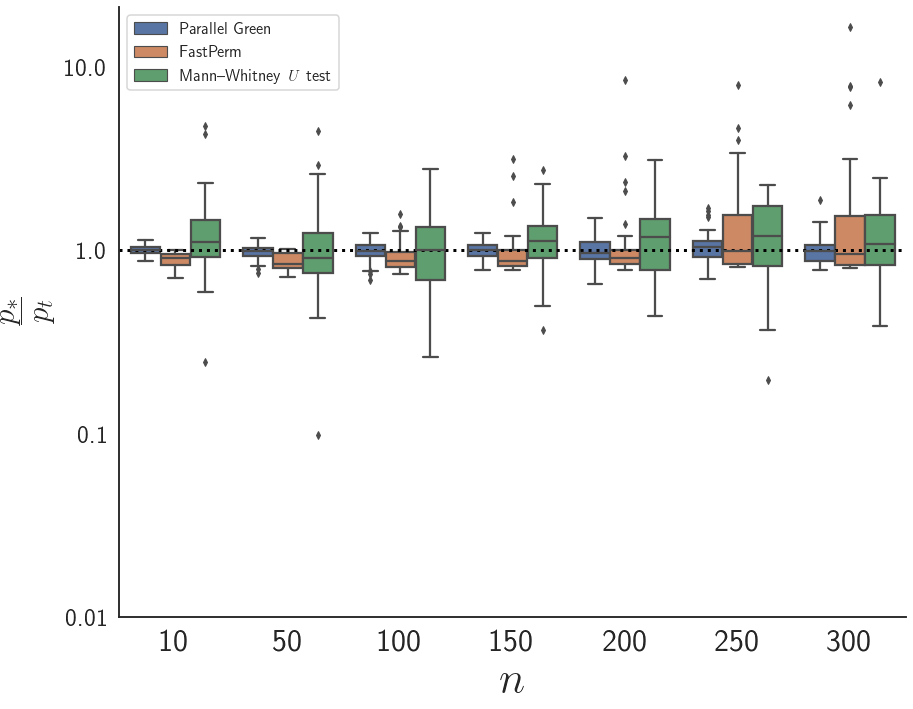

In [84]:
SNSMultipleboxPlot(allFracList1, setSize, allFracMWUList1, 
                   allFracFPList1, 
                   relError=False,
                   path="./figures/accuracy/comparison/02",
                  dashed=True)

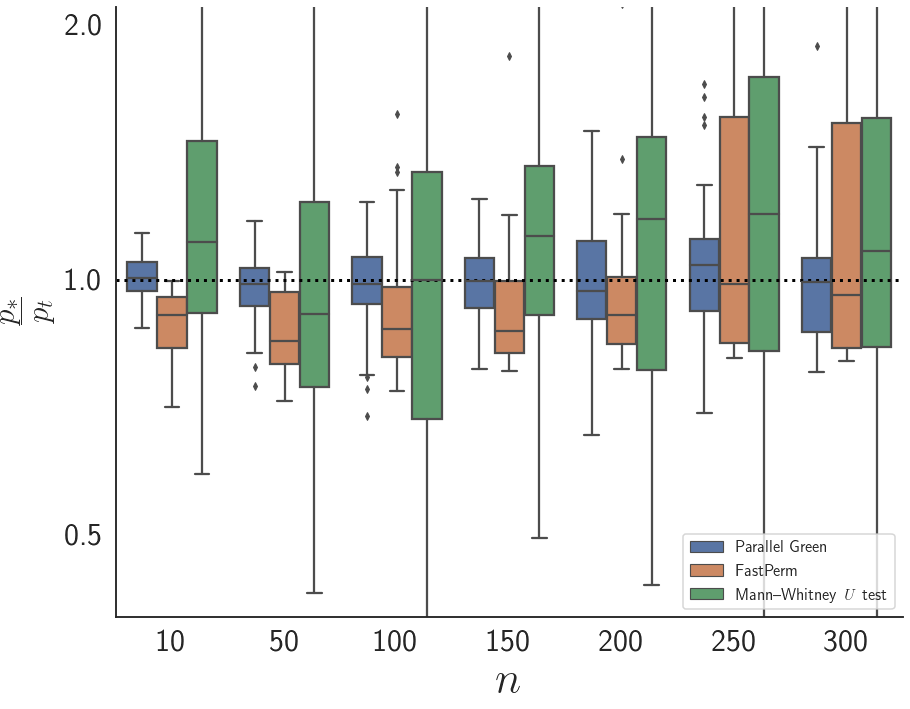

In [85]:
SNSMultipleboxPlot(allFracList1, setSize, allFracMWUList1, 
                   allFracFPList1, 
                   relError=False,
                   path="./figures/accuracy/comparison/02",
                  dashed=True,ylim=[0.4, 2.1])

In [86]:
#allEerrorList2, allFracList2, allMWUList2, allFracMWUList2, allFPList2, allFracFPList2 = getPvalues(1)

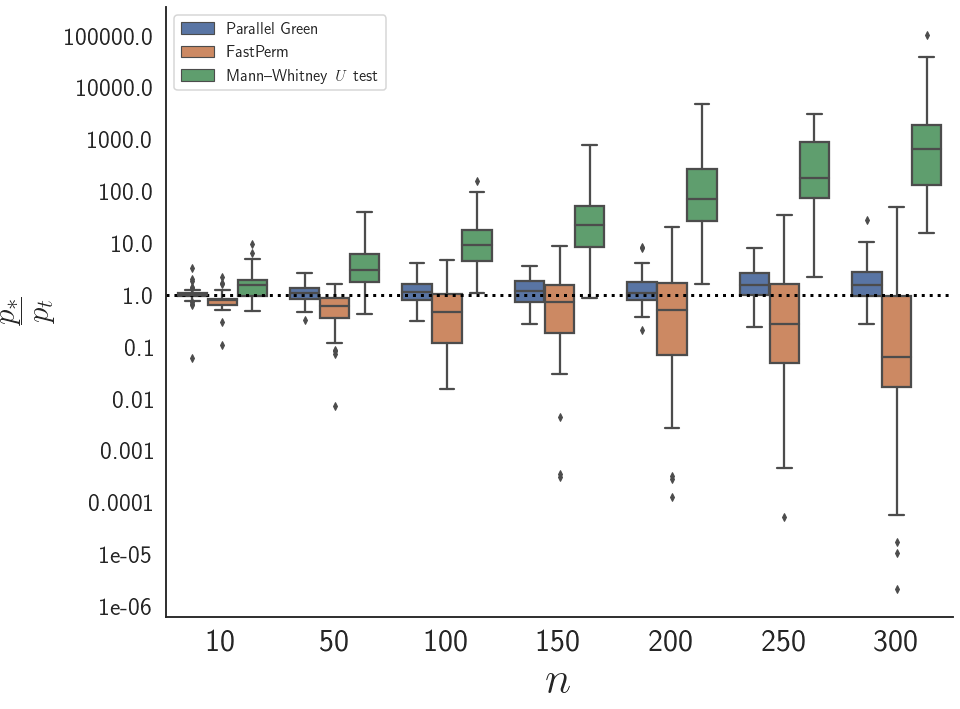

In [87]:
SNSMultipleboxPlot(allFracList2, setSize, allFracMWUList2, 
                   allFracFPList2, relError=False,
                   path="./figures/accuracy/comparison/1", dashed=True)



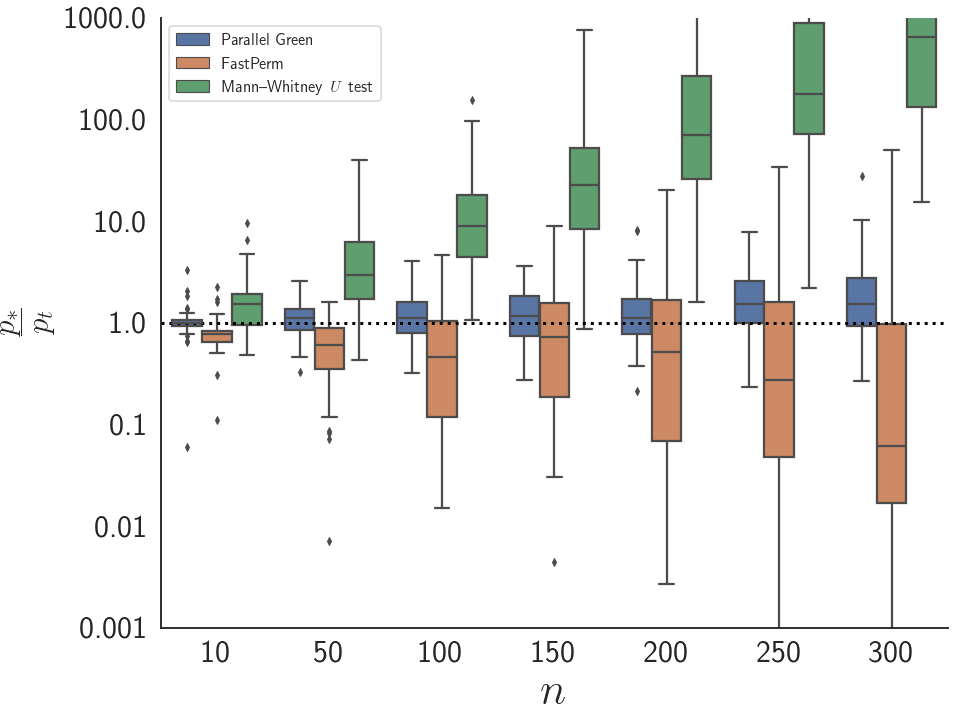

In [88]:
SNSMultipleboxPlot(allFracList2, setSize, allFracMWUList2, 
                   allFracFPList2, relError=False,path="./figures/accuracy/comparison/1", 
                   dashed=True, ylim=[10**-3, 10**3])



In [26]:
def getNwPlot(setSize, mean=0.1):
    N_w = list(range(5, 105,5))
    allEerrorNw, allEerrorNwFrac = list(), list()
    for n_w in N_w:
        Anorm0, Bnorm0 = getSynteticData(np.random.normal, mean=mean, setN=setSize,sampleN=50)
        ptTest  = ttests(Anorm0, Bnorm0)
    
        peList = exactTest(Anorm0, Bnorm0, bins=n_w)
        ExactErrorList = getErrors(peList, ptTest)
        ExactFracList = getErrors(peList, ptTest, False) 
        allEerrorNw.append(np.log10(np.abs(ExactErrorList)))
        allEerrorNwFrac.append(np.log10(ExactFracList))
    return allEerrorNwFrac, N_w
    
    

# |A|=|B|=10 $\mu =1$

In [27]:
n0 = setSize[0]; n0

10

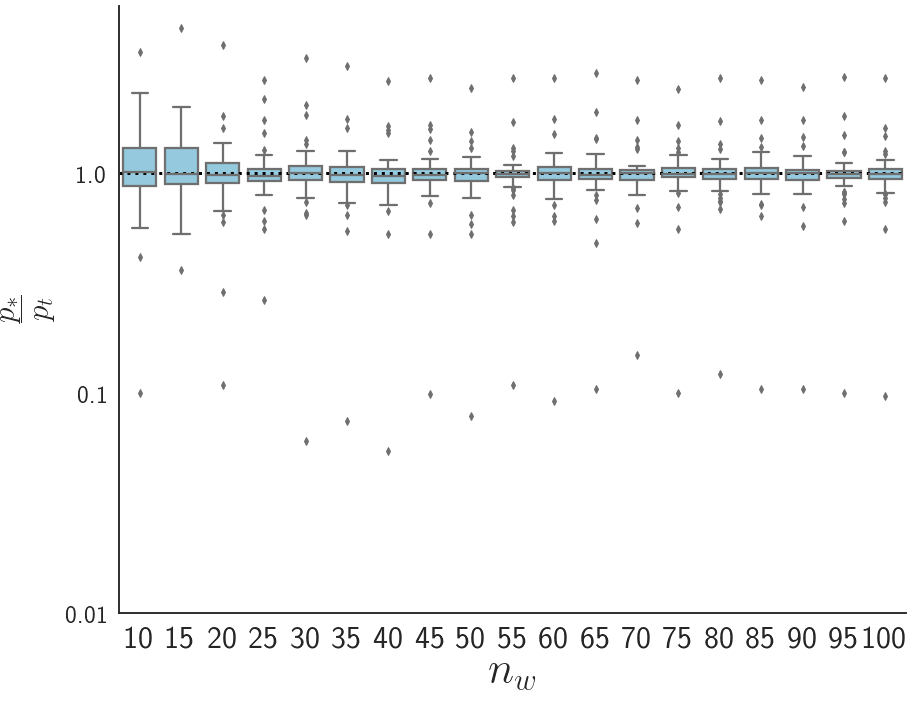

In [36]:
#allEerrorNwFrac0_m_1, N_w = getNwPlot(n0, mean=1.0)
SNSMultipleboxPlot(allEerrorNwFrac0_m_1[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/1_" + str(n0),
                  dashed=True)

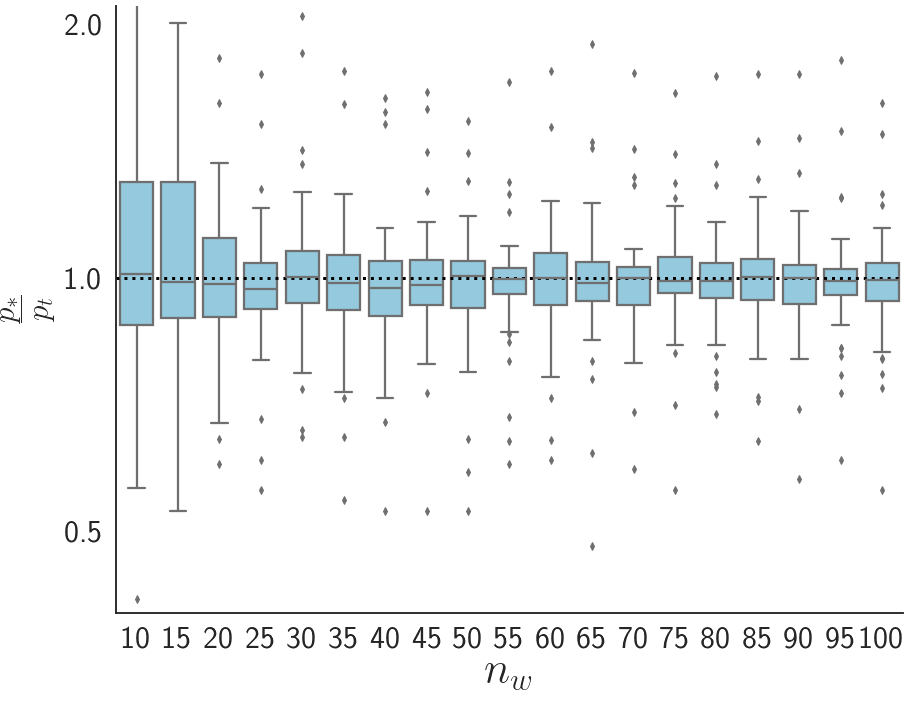

In [38]:
SNSMultipleboxPlot(allEerrorNwFrac0_m_1[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/1_" + str(n0),
                  dashed=True, ylim=[0.4, 2.1])

# |A|=|B|=10 $\mu =0.2$

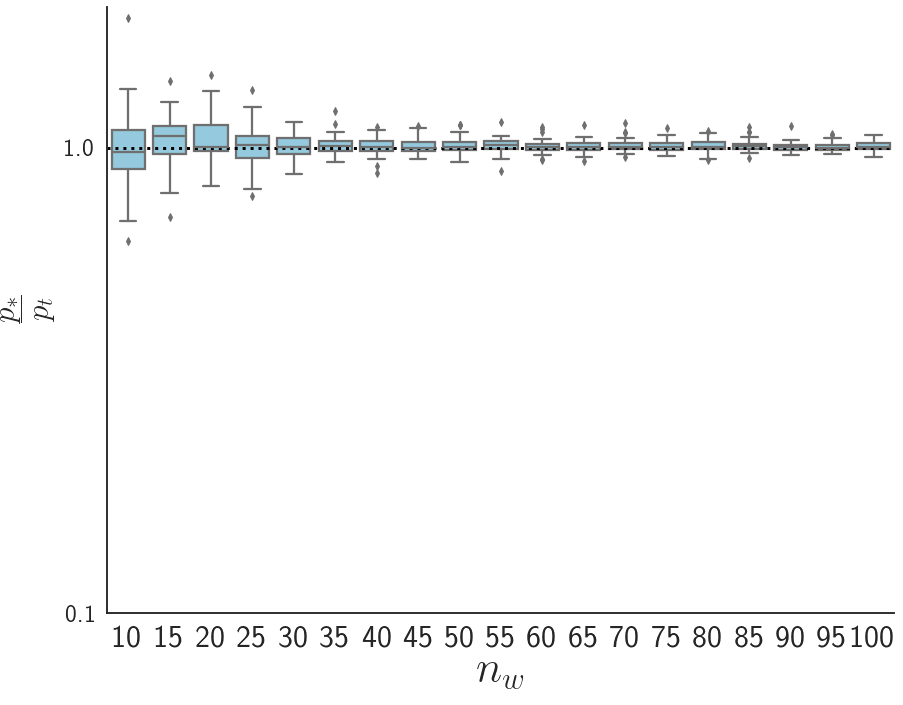

In [39]:
#allEerrorNwFrac0_m_02, N_w = getNwPlot(n0, mean=0.2)
SNSMultipleboxPlot(allEerrorNwFrac0_m_02[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/02_" + str(n0),
                  dashed=True)

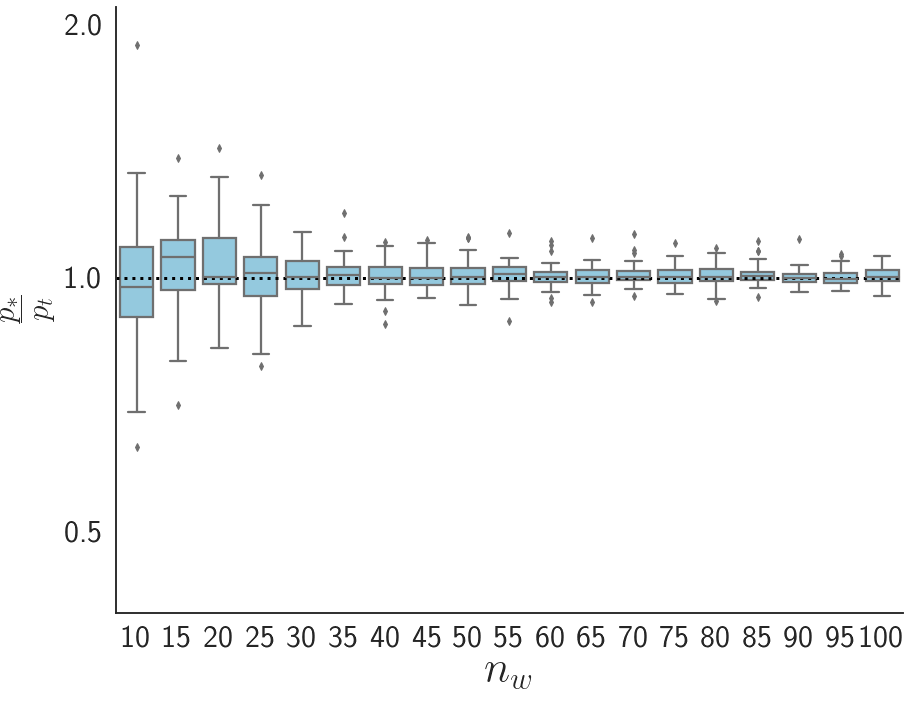

In [41]:
SNSMultipleboxPlot(allEerrorNwFrac0_m_02[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/02_" + str(n0),
                  dashed=True, ylim=[0.4, 2.1])

# |A|=|B|=50 $\mu =1$

In [42]:
n1 = setSize[1]; n1

50

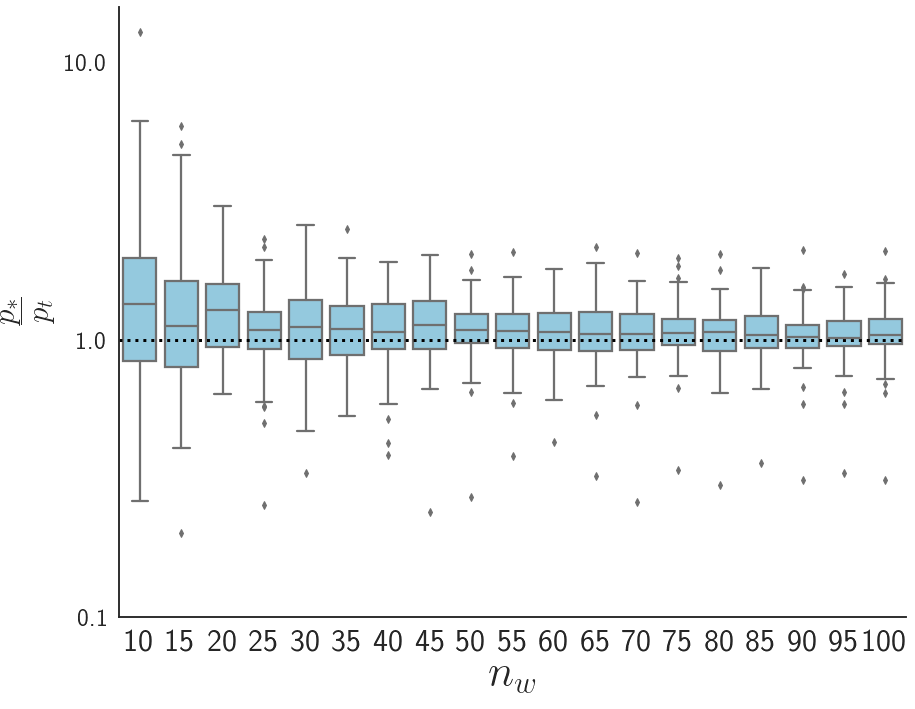

In [45]:
#allEerrorNwFrac1_m_1, N_w = getNwPlot(n1, 1)
SNSMultipleboxPlot(allEerrorNwFrac1_m_1[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/1_" + str(n1),
                  dashed=True)

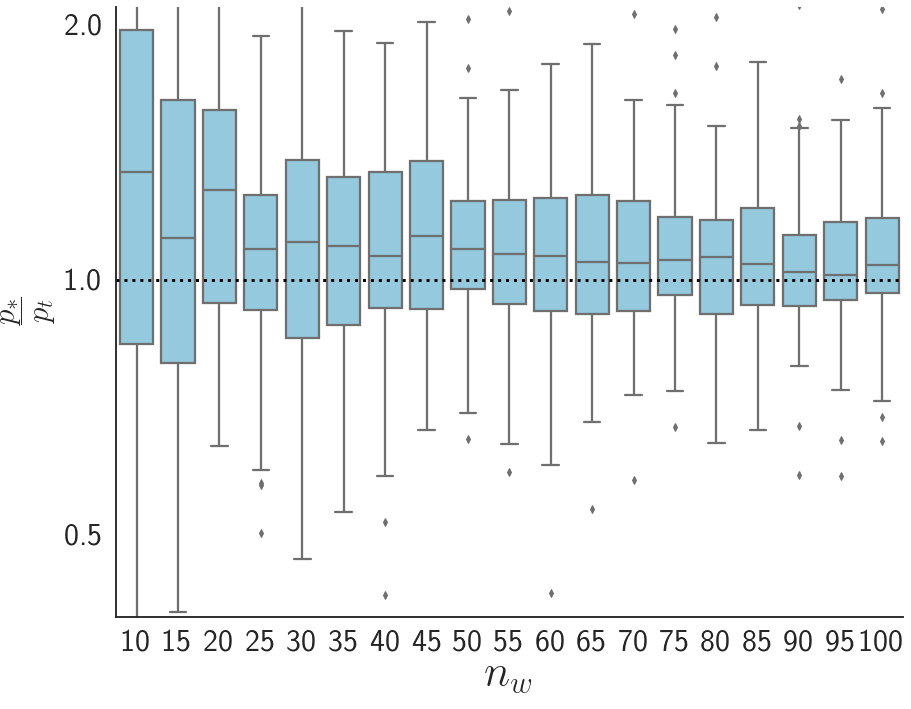

In [46]:
SNSMultipleboxPlot(allEerrorNwFrac1_m_1[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/1_" + str(n1),
                  dashed=True, ylim=[0.4, 2.1])

# |A|=|B|=50 $\mu =0.2$

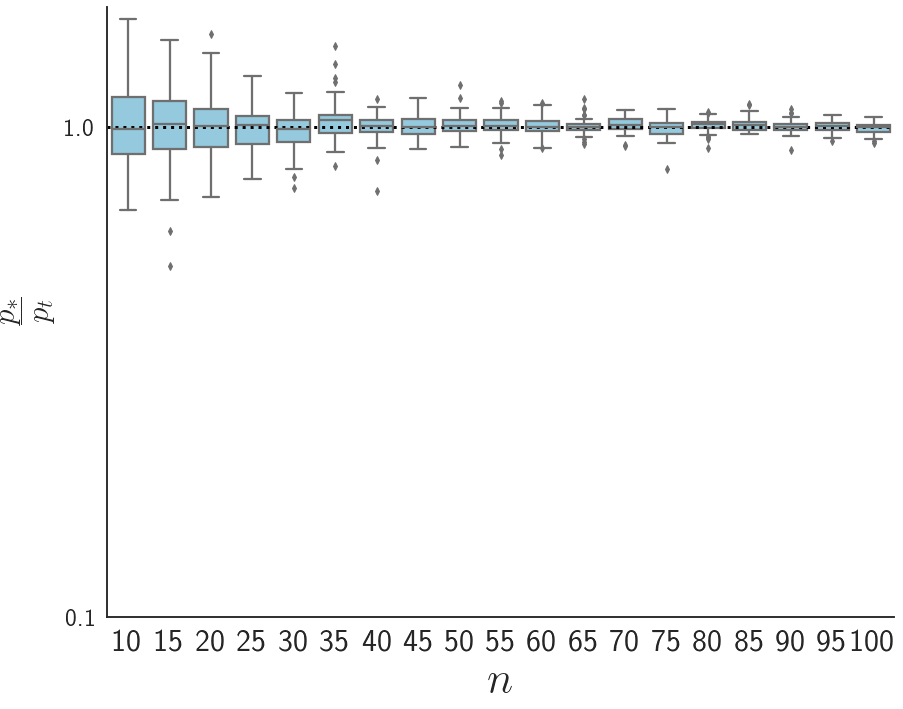

In [47]:
#allEerrorNwFrac1_m_02, N_w = getNwPlot(n1, 0.2)
SNSMultipleboxPlot(allEerrorNwFrac1_m_02[1:], N_w[1:], test_type="windowSize_s50_m02", 
                   relError=False,path="./figures/accuracy/windowSize/02_" + str(n1),
                  dashed=True)

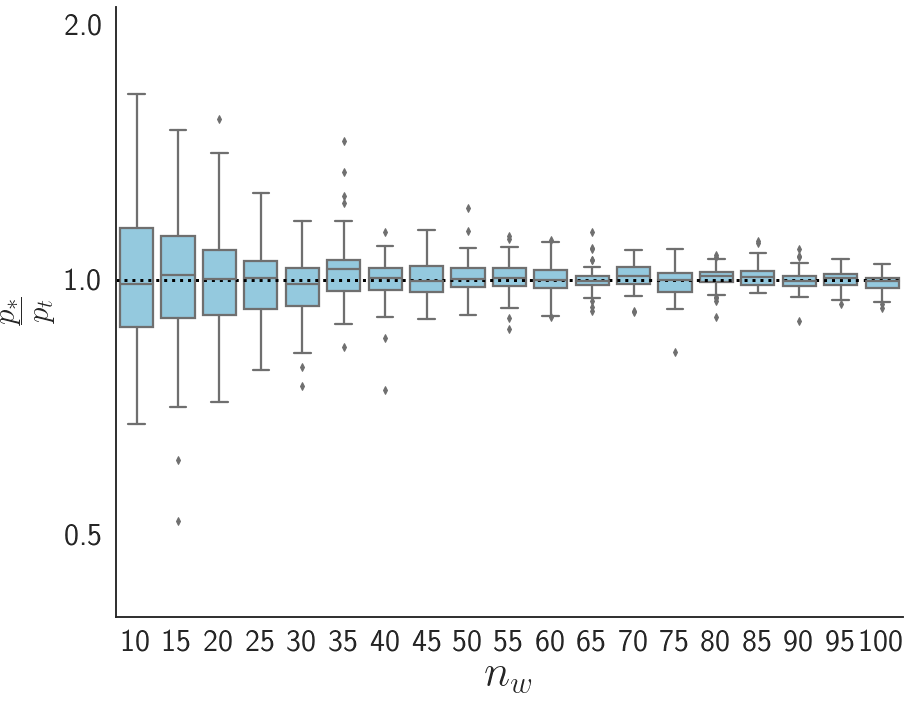

In [48]:
SNSMultipleboxPlot(allEerrorNwFrac1_m_02[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/02_" + str(n1),
                  dashed=True, ylim=[0.4, 2.1])

# |A|=|B|=100 $\mu =1$

In [49]:
n2 = setSize[2]; n2

100

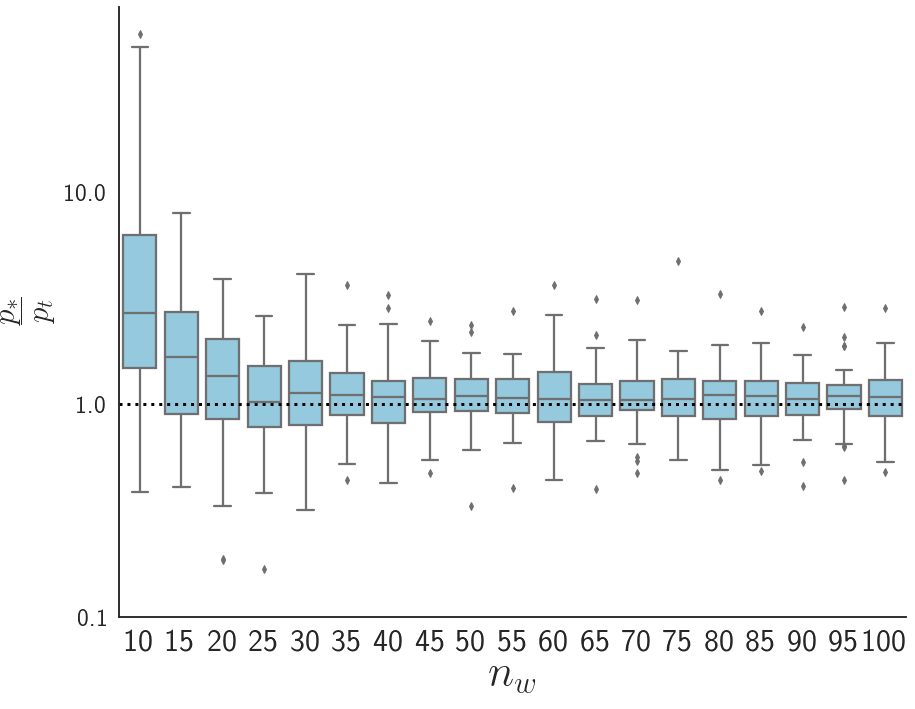

In [50]:
#allEerrorNwFrac2_m1, N_w = getNwPlot(n2, 1)
SNSMultipleboxPlot(allEerrorNwFrac2_m1[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/1_" + str(n2),
                  dashed=True)

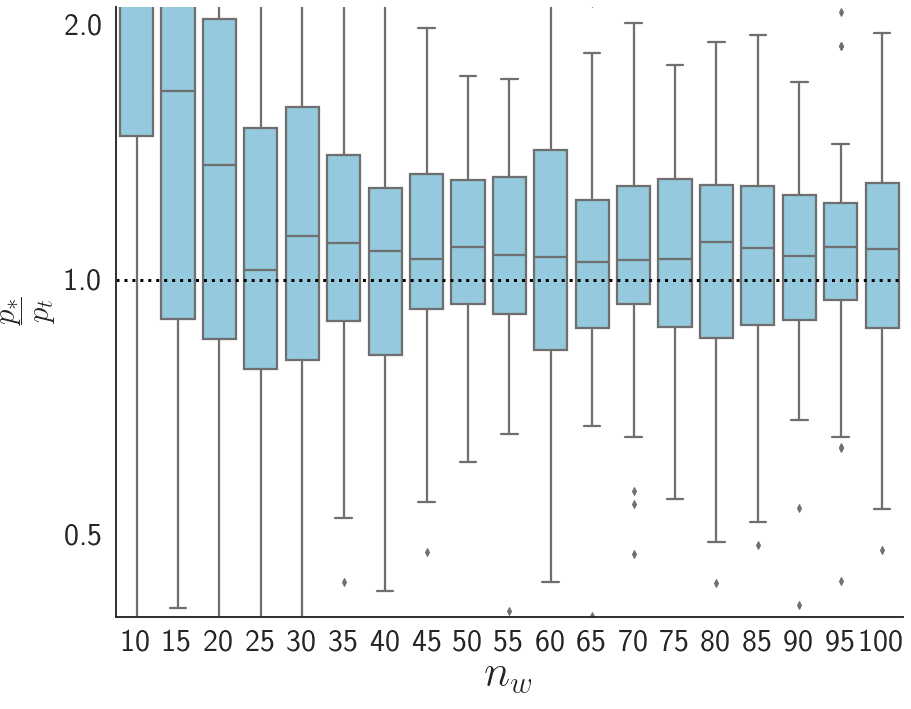

In [51]:
SNSMultipleboxPlot(allEerrorNwFrac2_m1[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/1_" + str(n2),
                  dashed=True, ylim=[0.4, 2.1])

# |A|=|B|=100 $\mu =0.2$

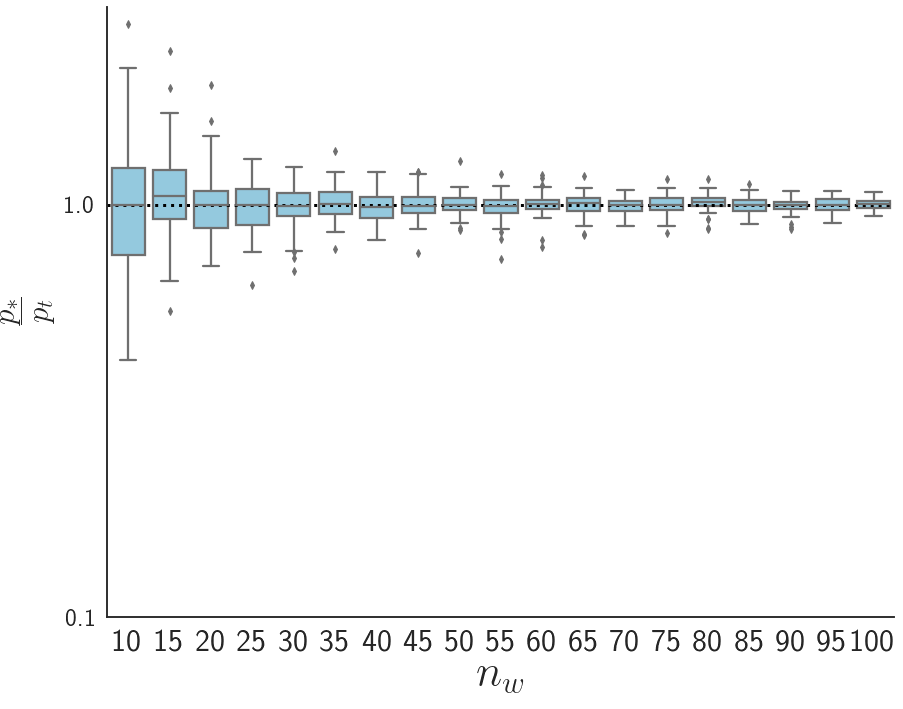

In [52]:
#allEerrorNwFrac2_m_02, N_w = getNwPlot(n2, 0.2)
SNSMultipleboxPlot(allEerrorNwFrac2_m_02[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/02_" + str(n2),
                  dashed=True)

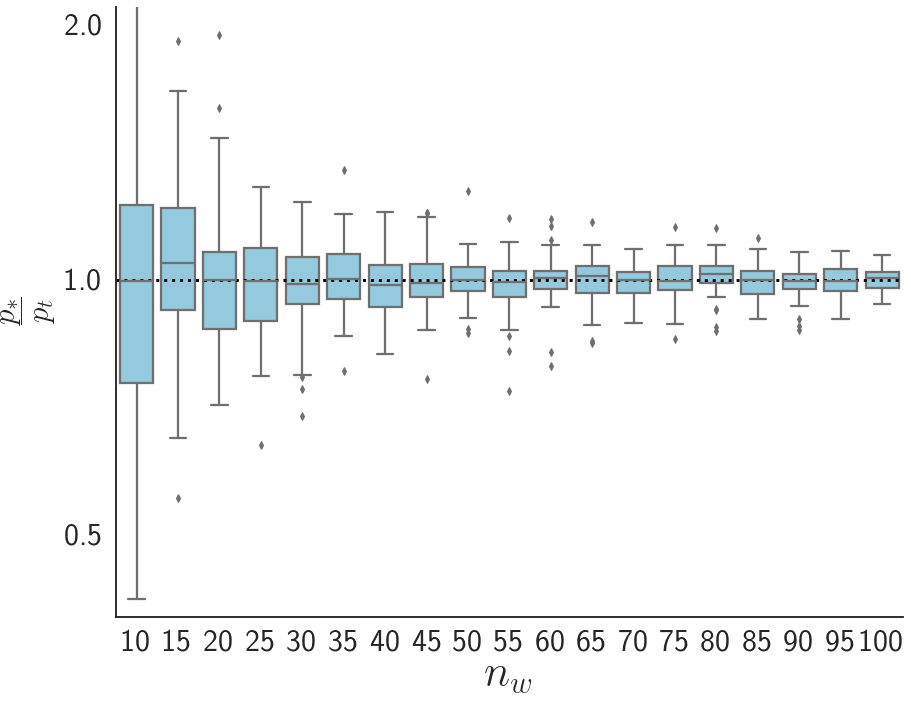

In [53]:
SNSMultipleboxPlot(allEerrorNwFrac2_m_02[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/02_" + str(n2),
                  dashed=True, ylim=[0.4, 2.1])

# |A|=|B|=150 $\mu = 1$

In [54]:
n3 = setSize[3]; n3

150

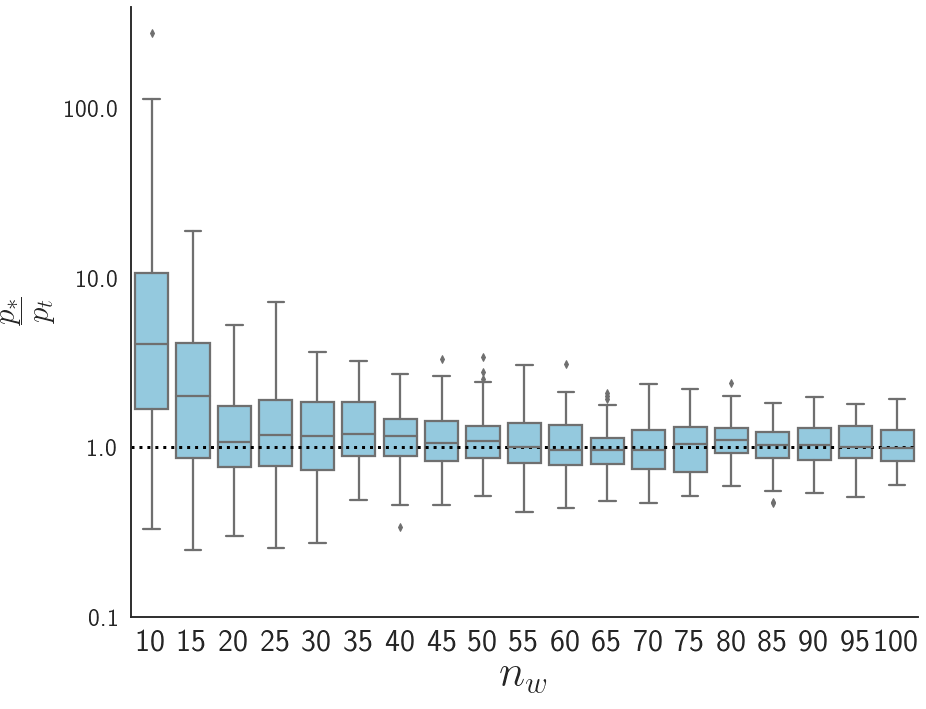

In [56]:
#allEerrorNwFrac3_m_1, N_w = getNwPlot(n3, 1)

SNSMultipleboxPlot(allEerrorNwFrac3_m_1[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/1_" + str(n3),
                  dashed=True)

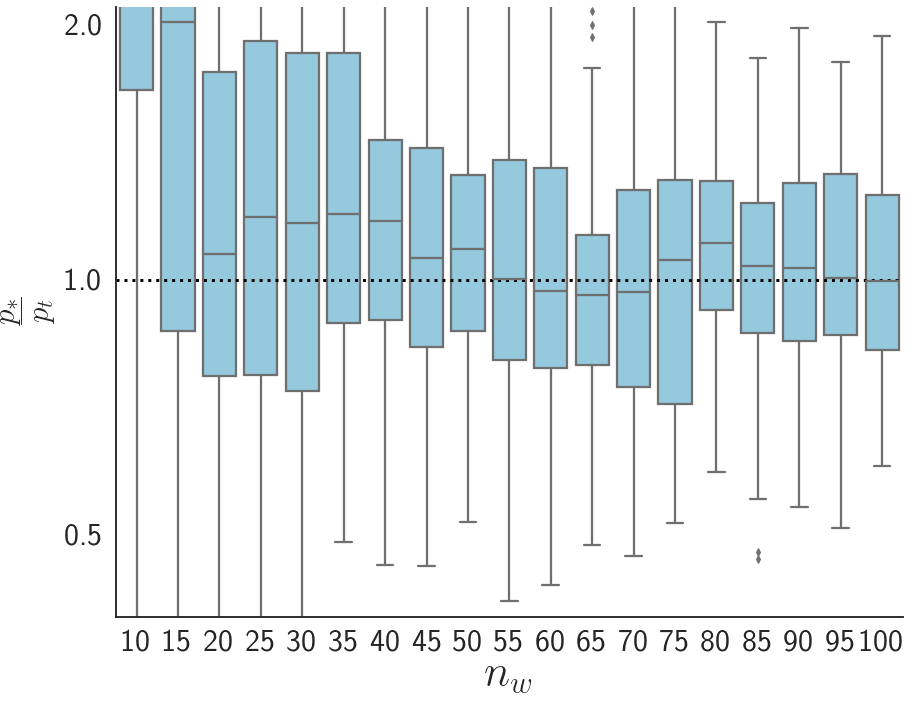

In [57]:
SNSMultipleboxPlot(allEerrorNwFrac3_m_1[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/1_" + str(n3),
                  dashed=True, ylim=[0.4, 2.1])

# |A|=|B|=150 $\mu = 0.2$

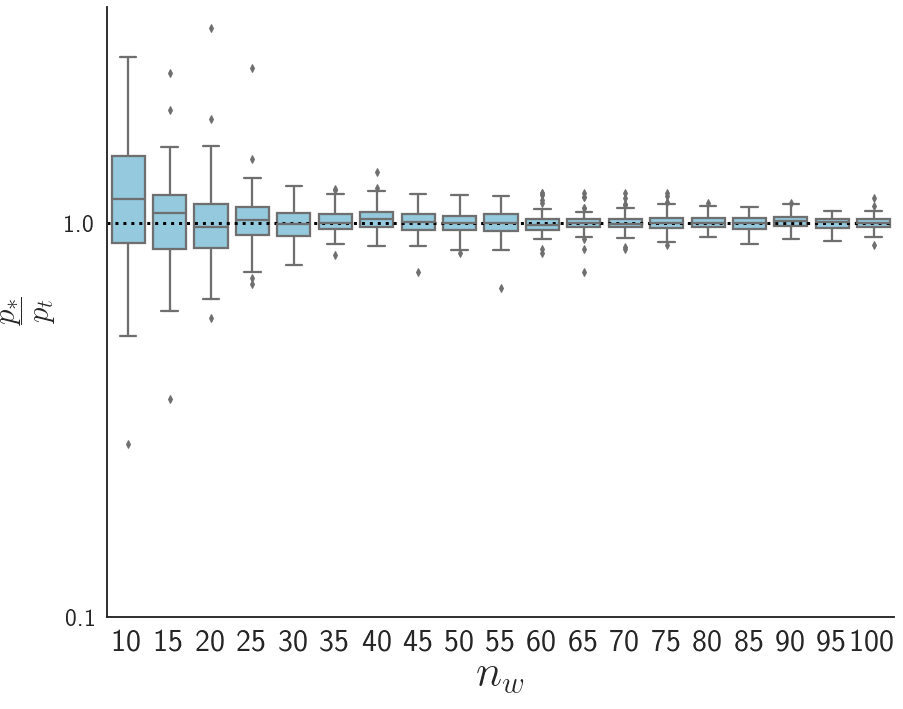

In [59]:
#allEerrorNwFrac3_m_02, N_w = getNwPlot(n3, 0.2)

SNSMultipleboxPlot(allEerrorNwFrac3_m_02[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/02_" + str(n3),
                  dashed=True)

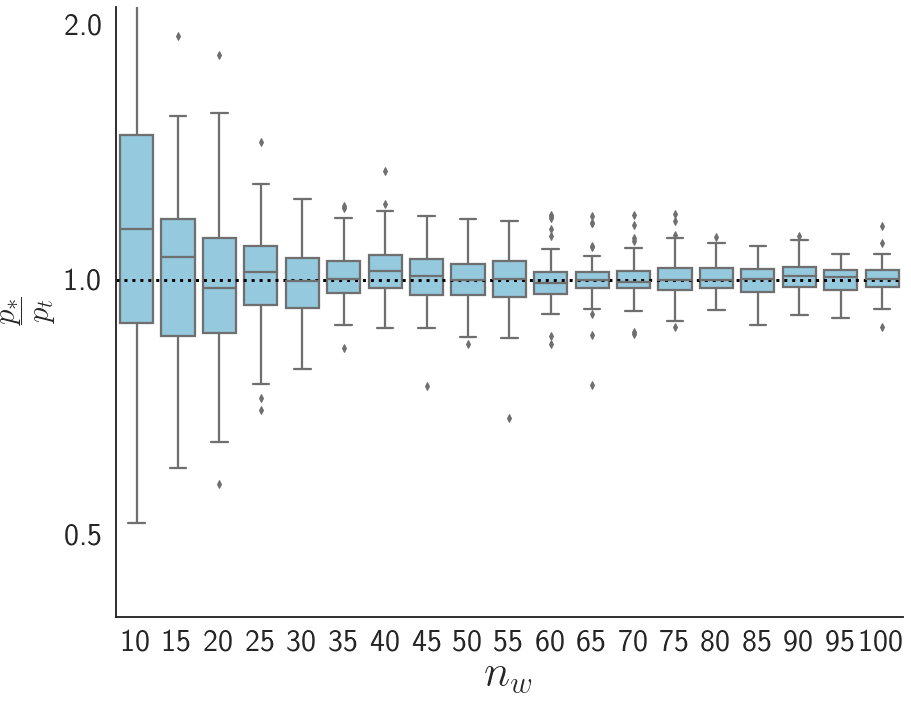

In [60]:
SNSMultipleboxPlot(allEerrorNwFrac3_m_02[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/02_" + str(n3),
                  dashed=True, ylim=[0.4, 2.1])

# |A|=|B|=200 $\mu = 1$

In [61]:
n4 = setSize[4]; n4

200

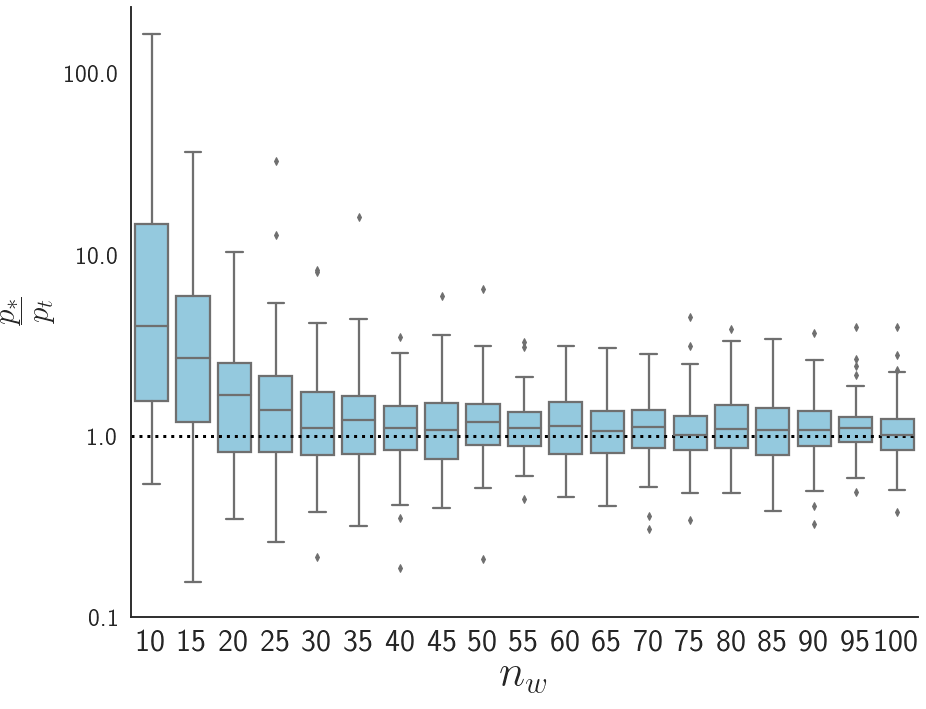

In [63]:
#allEerrorNwFrac4_m1, N_w = getNwPlot(n4,1)
SNSMultipleboxPlot(allEerrorNwFrac4_m1[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/1_" + str(n4),
                  dashed=True)

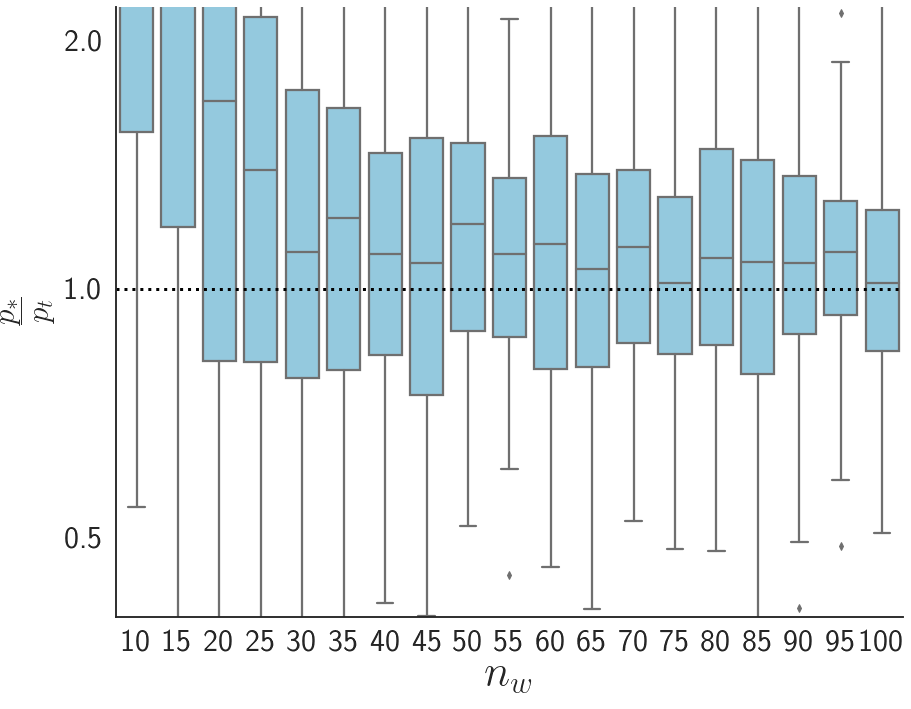

In [64]:
SNSMultipleboxPlot(allEerrorNwFrac4_m1[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/1_" + str(n4),
                  dashed=True, ylim=[0.4, 2.2])

# |A|=|B|=200 $\mu = 0.2$

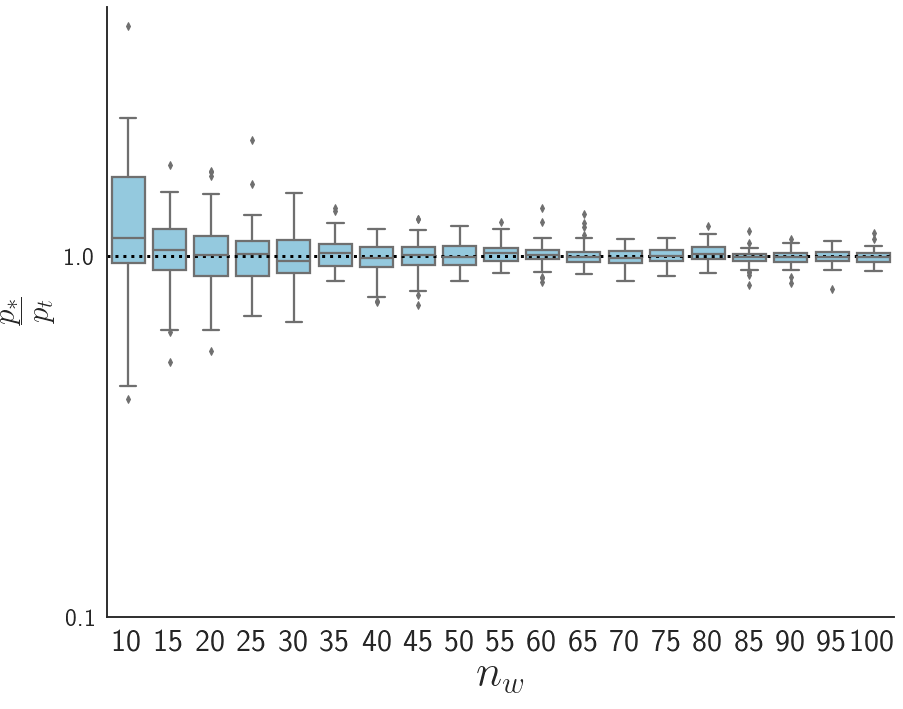

In [66]:
#allEerrorNwFrac4_m02, N_w = getNwPlot(n4,0.2)
SNSMultipleboxPlot(allEerrorNwFrac4_m02[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/02_" + str(n4),
                  dashed=True)

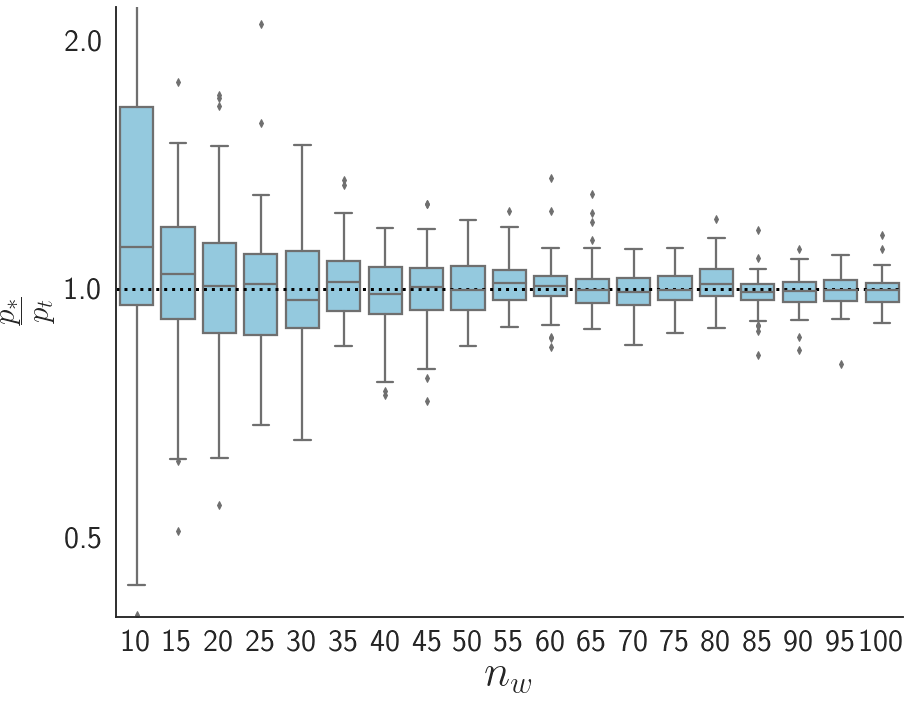

In [67]:
SNSMultipleboxPlot(allEerrorNwFrac4_m02[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/02_" + str(n4),
                  dashed=True, ylim=[0.4, 2.2])

# |A|=|B|=250 $\mu =1$

In [68]:
n5 = setSize[5]; n5

250

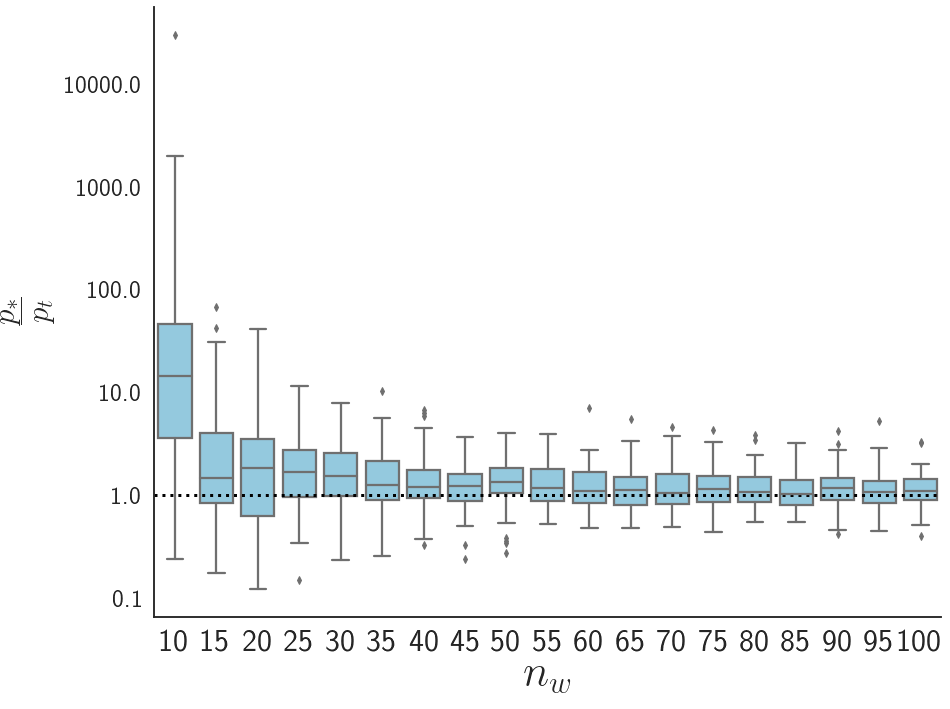

In [70]:
#allEerrorNwFrac5_m1, N_w = getNwPlot(n5,1)
SNSMultipleboxPlot(allEerrorNwFrac5_m1[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/1_" + str(n5),
                  dashed=True)

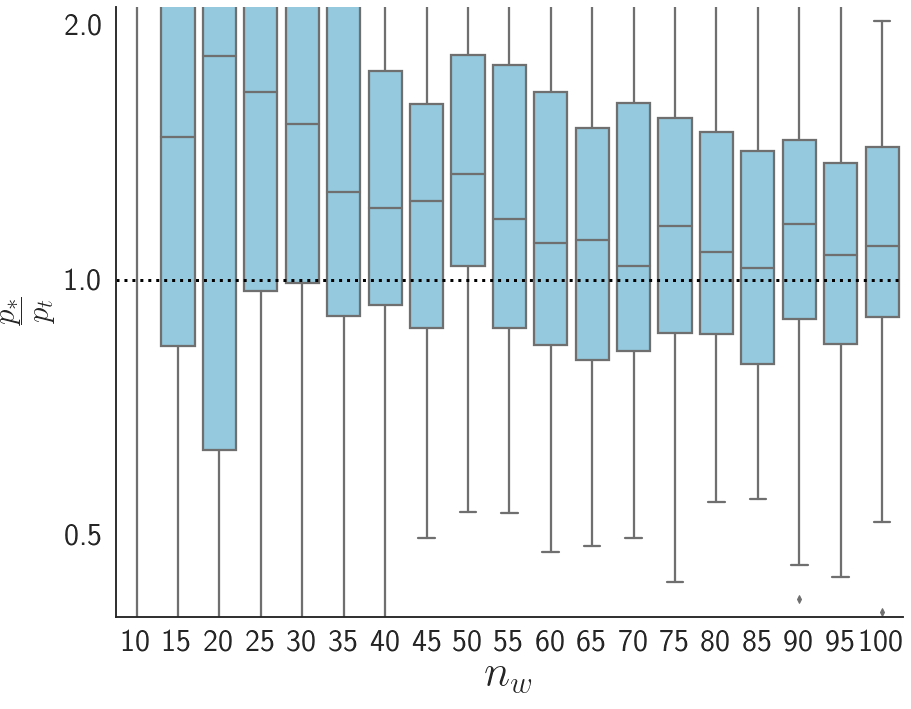

In [71]:
SNSMultipleboxPlot(allEerrorNwFrac5_m1[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/1_" + str(n5),
                  dashed=True, ylim=[0.4, 2.1])

# |A|=|B|=250 $\mu =0.2$

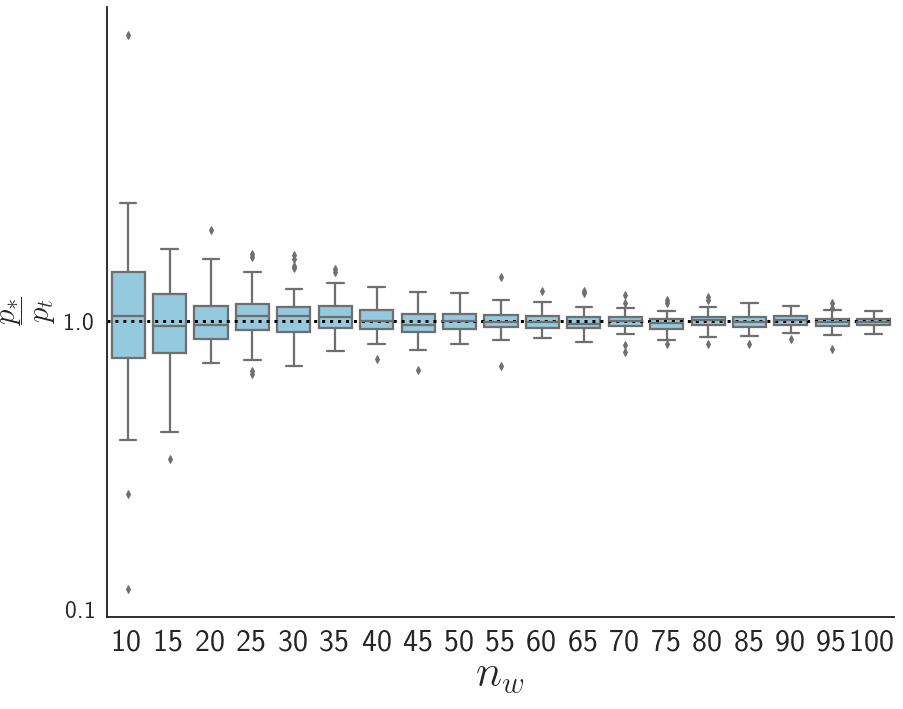

In [73]:
#allEerrorNwFrac5_m02, N_w = getNwPlot(n5,0.2)
SNSMultipleboxPlot(allEerrorNwFrac5_m02[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/02_" + str(n5),
                  dashed=True)

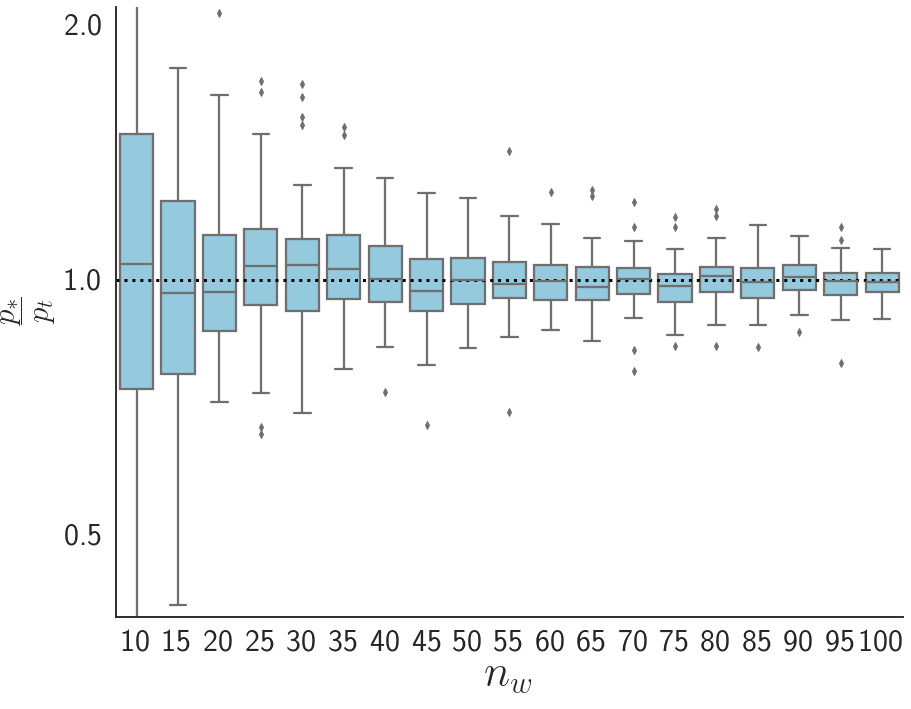

In [74]:
SNSMultipleboxPlot(allEerrorNwFrac5_m02[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/02_" + str(n5),
                  dashed=True, ylim=[0.4, 2.1])

# |A|=|B|=300 $\mu =1$


In [75]:
n6 = setSize[6];n6

300

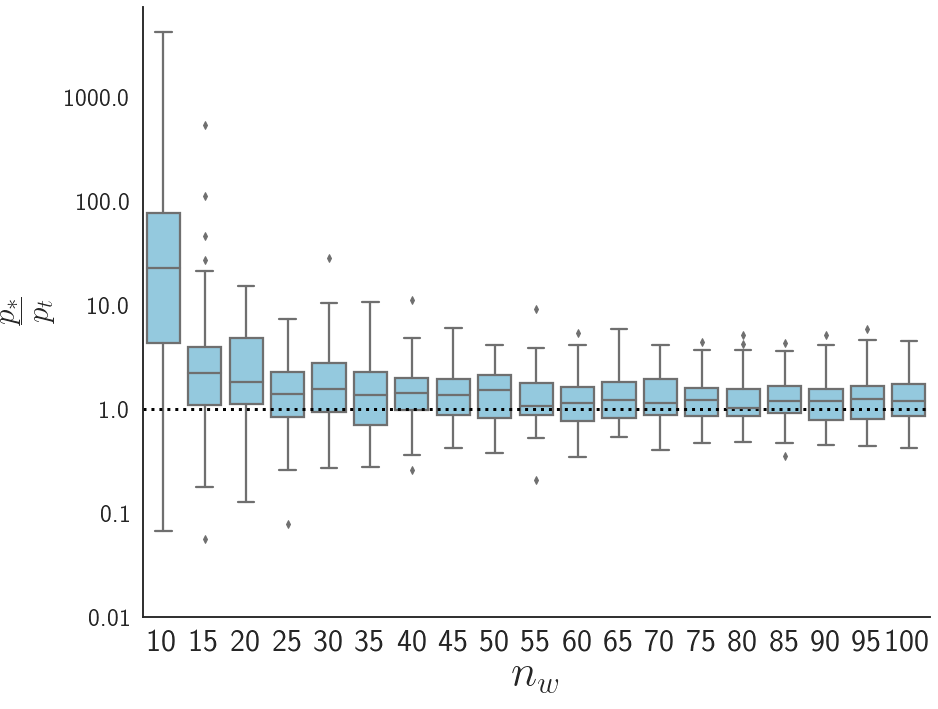

In [77]:
#allEerrorNwFrac6_m1, N_w = getNwPlot(n6, 1)
SNSMultipleboxPlot(allEerrorNwFrac6_m1[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/1_" + str(n6),
                  dashed=True,
                  )

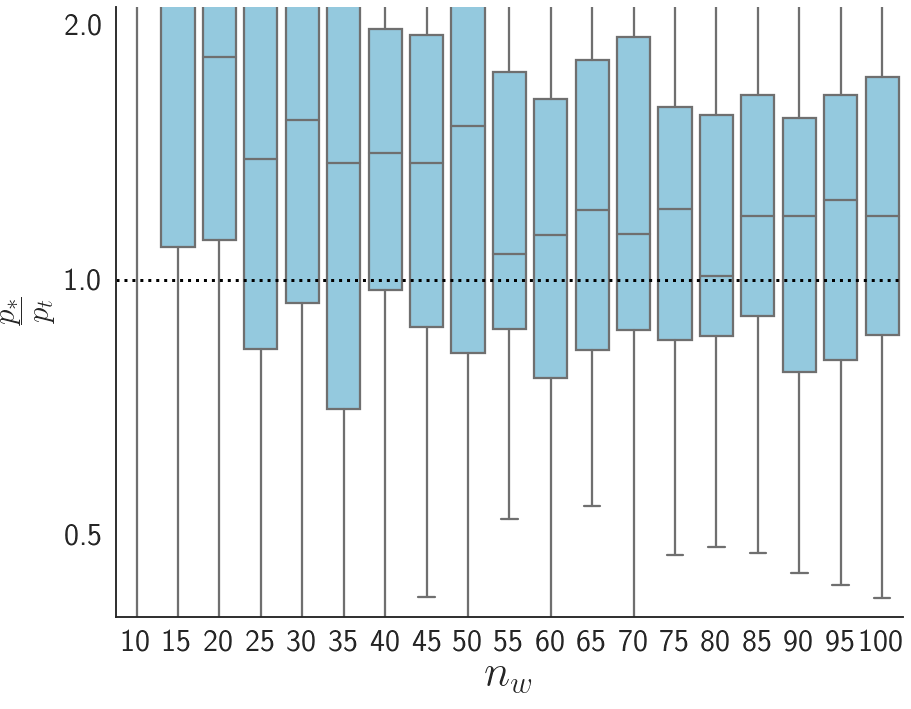

In [78]:
SNSMultipleboxPlot(allEerrorNwFrac6_m1[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/1_" + str(n6),
                  dashed=True,ylim=[0.4, 2.1]
                  )

# |A|=|B|=300 $\mu =0.2$

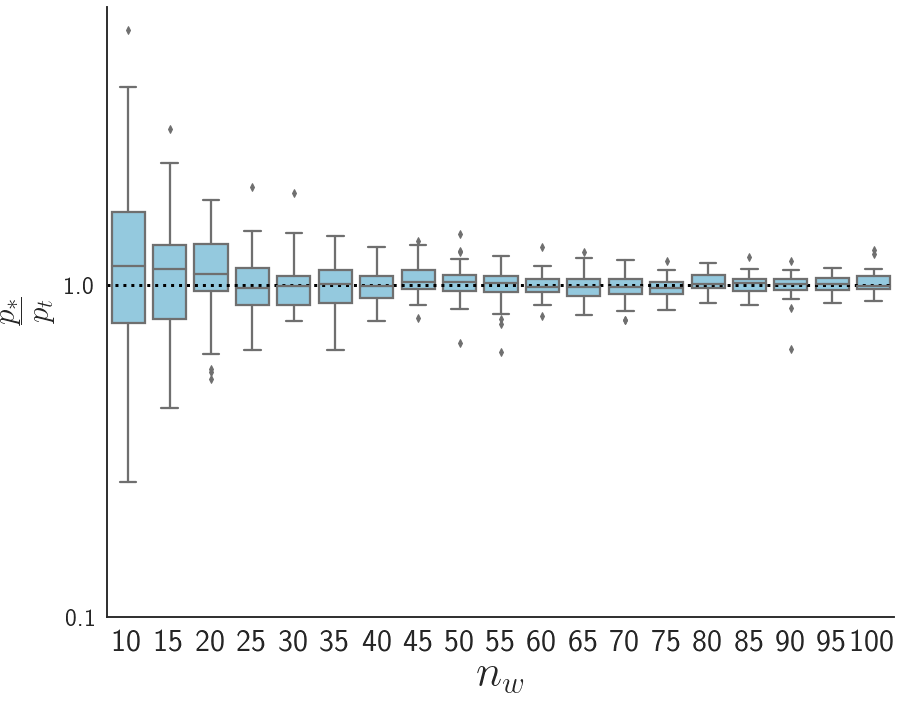

In [80]:
#allEerrorNwFrac6_m02, N_w = getNwPlot(n6, 0.2)
SNSMultipleboxPlot(allEerrorNwFrac6_m02[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/02_" + str(n6),
                  dashed=True,
                  )

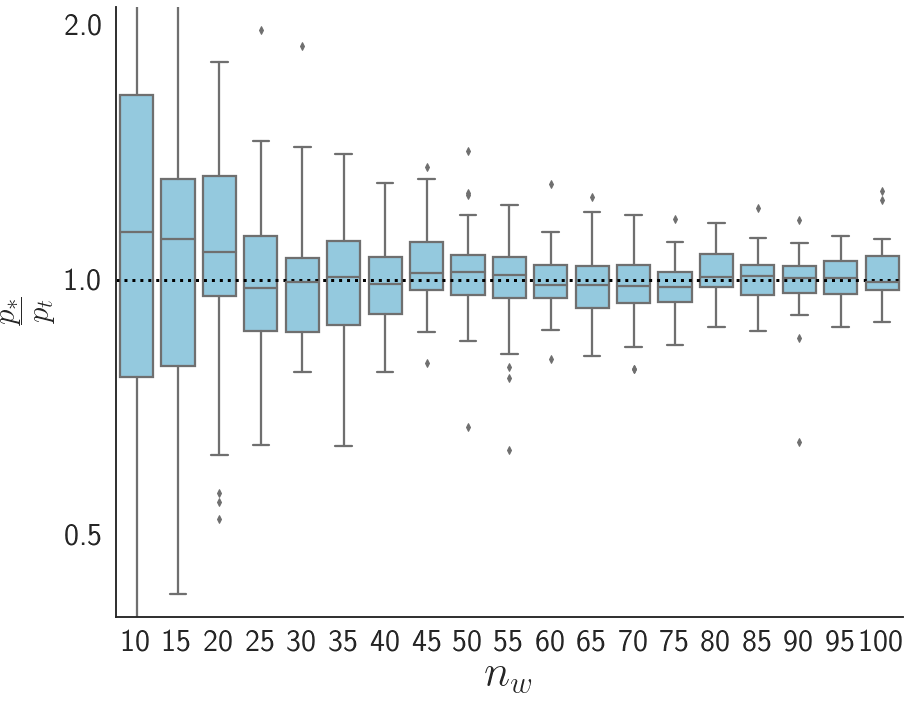

In [81]:
SNSMultipleboxPlot(allEerrorNwFrac6_m02[1:], N_w[1:], test_type="windowSize", 
                   relError=False,path="./figures/accuracy/windowSize/02_" + str(n6),
                  dashed=True,ylim=[0.4, 2.1]
                  )